
# Influence-Based Rewards

The only actually meaningful reward of a board game comes (if at all) with the last and winning move. That makes learning almost impossible. Ideally, we would use a function $R(s, a)$ that rewards the immediate impact of every single move. Here, we devise a reasonable canditate for such a function. Note, however, that our soft reward function must always be secondary to the true reward function that only rewards the line of five and nothing else.

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from domoku.board import GomokuBoard
from domoku.data import create_binary_action, create_binary_rep
from domoku.rewards import InfluenceModel, RewardContext
from domoku.constants import *
from domoku.tools import GomokuTools as gt

def print_bin(binary_sample):
    print(f'shape: {binary_sample.shape}')
    print(np.rollaxis(binary_sample, 2, 0)[0] + 2 * np.rollaxis(binary_sample, 2, 0)[1])

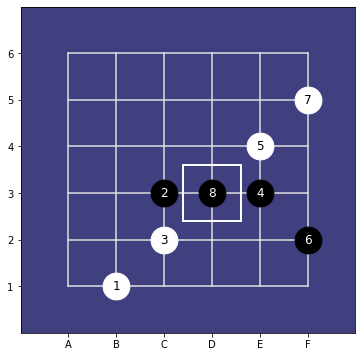

In [3]:
stones = gt._string_to_stones('b1c3c2e3e4f2f5d3')
board = GomokuBoard(n=6, disp_width=6, stones=stones)
board.display()

---

### Representing the board and the moves

Unless explicitly switched, the board is always represented from the point of view of the current player, which is the next one to move.
Every board consists of two layers (channels in the context of CNNs) the first of which represents the stones of the current player
The printer function uses the integer 2 for a stone on the second layer. You see: Black is the one to move next, hence black is 1 and white is represented by 2.

In [4]:
np_sample = create_binary_rep(board.N, board.stones, board.current_color)
print_bin(np_sample)

shape: (6, 6, 2)
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 2. 2. 2. 0.]
 [0. 0. 1. 0. 0. 2.]
 [0. 1. 0. 0. 0. 0.]]


---

### Padding and borders

To support consistent workings of a CNN we pad the board representation such that the output of the first CNN layer recreates the original board size. The additional fields right next to the original board are populated with defensive stones (stones on the 'other' layer). All analyses will always consider the offensive power of the current player, hence those boarder stones will never be detected as threats but only as obstructions to the current player's stones.

In [5]:
np_sample = create_binary_rep(board.N, board.stones, board.current_color, padding=4, border=True)
print_bin(np_sample)

shape: (14, 14, 2)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 1. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 2. 2. 2. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 1. 0. 0. 2. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 1. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [6]:
action = create_binary_action(board_size=6, padding=4, position=(B, 3))
print_bin(action + np_sample)

shape: (14, 14, 2)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 1. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 1. 2. 2. 2. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 1. 0. 0. 2. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 1. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


---

### Switching the board

We can look at any board from the 'other' player's point of view to judge the need for a defensive play. Note that the border representation is still on the second plane.

In [7]:
np_sample_switched = create_binary_rep(board.N, board.stones, board.current_color,
                                       padding=4, border=True, switch=True)
print_bin(np_sample_switched)

shape: (14, 14, 2)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 2. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 2. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 1. 1. 1. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 2. 0. 0. 1. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 2. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [8]:
action_switched = create_binary_action(6, 4, (B, 3), switch=True)
print_bin(action_switched + np_sample_switched)

shape: (14, 14, 2)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 2. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 2. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 2. 1. 1. 1. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 2. 0. 0. 1. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 2. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


---

### Rewarding gains of influence

Any stone (including border stones) is modelled to influence empty fields that are close enough on the same diagonal, vertical or horizontal line as the stone itself. A stone's influence has a natural range of 4.

This influence function can be efficiently computed with the help of a CNN with radial filters for each of the 4 directions

The total influence of all neighboring stones on a particular field $(i, j)$ is computed as the geometric sum of the four directional influences:
$$
I(s, i, j) = (\sum_{d \in \mathbb{D}} I_d(s, i, j)^{\tau})^{\frac{1}{\tau}
$$

Here, $\tau = 2$ would mean, we use the classical cartesian sum, but other values for $\tau$ may turn out to be more appropriate

In [9]:
board_size = 15

In [10]:
model = InfluenceModel(board_size=board_size, current_influence=[[1, 2, 4, 8], [1, 2, 4, 8]], curr_tau=2, other_tau=2)

2022-05-21 16:23:47.674534: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


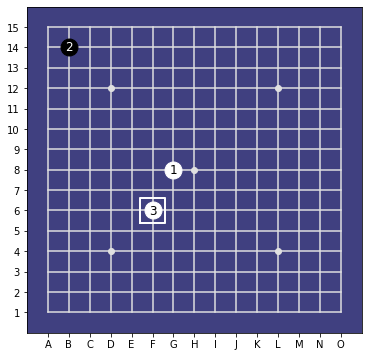

In [11]:
board = GomokuBoard(n=board_size, disp_width=6, stones=[(G, 8), (B, 14), (F, 6)])
board.display()

In [12]:
board_state = create_binary_rep(board.N, board.stones, board.current_color,
                                padding=4, border=True, switch=True)

### Visualizing the influence

We visualize the influence of the black stones

In [13]:
model.influence_of(board_state)

<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 5., 4., 4., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 6., 0., 6., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 4., 9., 9., 4., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 6., 0., 6., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 4., 4., 5., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

### Understanding *Influence* and Reward

You can see from the array above that the fields right between the two black stones are slightly higher valued (due to the cartesian sum) than the other fields directly surrounding the black stones. We can also recognize the defensiv power of the left and lower boarder, as they reduce the influence of the black stones.

Now, the reward is defined from here on as the gain of influence of the current player minus the gain of influence of the other player.
The gain of influence is the difference of influence between the states after and before the intended action.

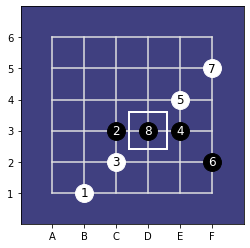

In [14]:
board = GomokuBoard(n=6, disp_width=4)
board.set(B, 1).set(C, 3).set(C, 2).set(E, 3).set(E, 4).set(F, 2).set(F, 5).set(D, 3).display()

In [15]:
model = InfluenceModel(board_size=board.N, current_influence=[[1, 2, 4, 8], [1, 2, 4, 8]], curr_tau=2, other_tau=2)
context = RewardContext(board, model)

In [16]:
for move in [(B, 3), (B, 4), (C, 4), (D, 4), (D, 5), (E, 5), (D, 2), (E, 2)]:
    print(context.reward(move))

(318.0, False)
(313.0, False)
(247.0, False)
(222.0, False)
(244.0, False)
(114.0, False)
(101.0, False)
(140.0, False)


In [17]:
np_sample = create_binary_rep(board.N, board.stones, board.current_color, padding=4, border=True)
action = create_binary_action(board.N, 4, (B, 4))
model.influence_of(np_sample + action)

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 0., 1., 0.],
       [0., 0., 9., 9., 0., 0.],
       [0., 9., 0., 0., 0., 0.],
       [0., 8., 0., 0., 0., 0.],
       [0., 0., 2., 0., 0., 0.]], dtype=float32)>

### Fine-Tuning the reward parameters

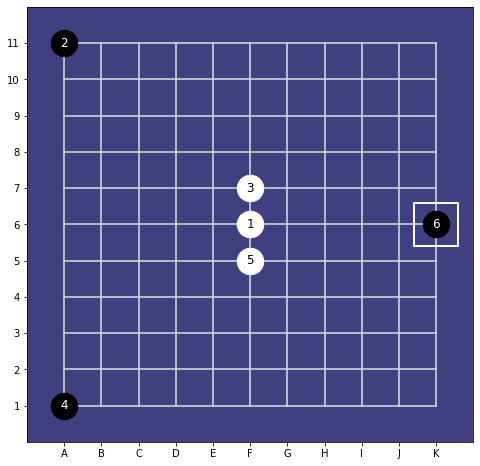

In [18]:
board = GomokuBoard(n=11, disp_width=8)
board.set(F, 6).set(A, 11).set(F, 7).set(A, 1).set(F, 5).set(K, 6).display()
model = InfluenceModel(board_size=board.N,
                       current_influence=[[.24, .28, .32, .35],[.24, .28, .32, .35]],
                       other_influence=[[0, .2, .4, 12],[0, .2, .4, 12]],
                       curr_tau=2, other_tau=2)
context = RewardContext(board, model)

In [19]:
for move in [(F, 8), (E, 5), (E, 6), (E, 7)]:
    print(context.reward(move))

(1.3309998512268066, False)
(2.5515997409820557, False)
(3.083399772644043, False)
(2.5515997409820557, False)


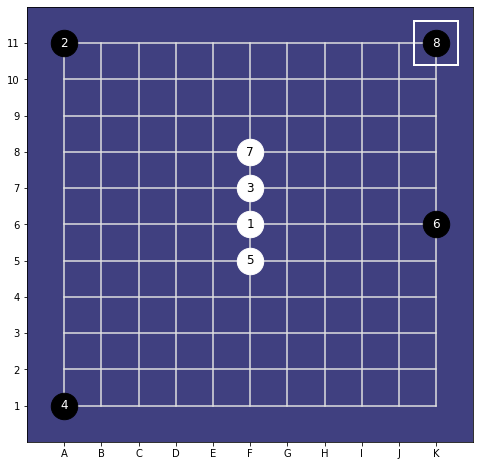

In [20]:
board.set(F, 8).set(K, 11).display()

## Overriding terminal reward

We can see that actions (F, 4) and (F, 9) will each result in the terminal reward

In [21]:
for move in [(F, 4), (E, 5), (E, 6), (E, 7), (F, 9)]:
    print(context.reward(move))

(100.0, True)
(2.343599796295166, False)
(3.083399772644043, False)
(2.9081997871398926, False)
(100.0, True)


# Super-Critical Line-of-4 Threats

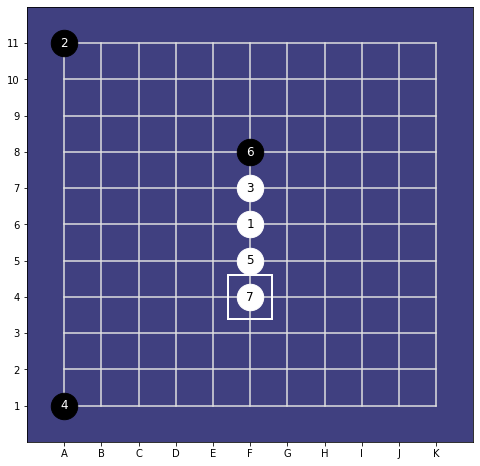

In [22]:
board = GomokuBoard(n=11, disp_width=8)
board.set(F, 6).set(A, 11).set(F, 7).set(A, 1).set(F, 5).set(F, 8).set(F, 4).display()

In [23]:
context = RewardContext(board, model)

#### All but the rescue move come with negative terminal reward. Good!

In [24]:
for move in [(F, 3), (E, 5), (E, 6), (E, 7), (F, 9)]:
    print(context.reward(move))

(2.0988998413085938, False)
(-100, False)
(-100, False)
(-100, False)
(-100, False)


#### Detecting Line of four threats

In [25]:
np_sample = create_binary_rep(board.N, board.stones, board.current_color, padding=4, border=True, switch=True)
print_bin(np_sample)
model.is_lo4_threat(np_sample)

shape: (19, 19, 2)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0.]
 [0. 0. 0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0

<tf.Tensor: shape=(), dtype=bool, numpy=True>